## Run cell2location deconvolution (early paed)

In [1]:
import sys 
import os
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d")
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import hdf5plugin

# Import key analysis packages
import cell2location
import scvi


# Define repo path and add it to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


In [2]:
# Define paths for plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
results_path = os.path.join(repo_path, 'results')
model_path = os.path.join(repo_path, 'models')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [3]:
# Set pandas display options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [4]:
%load_ext autoreload
%autoreload 2
# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
#from plotting.utils import plot_grouped_boxplot, calc_figsize

In [5]:
# Set plot formatting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from matplotlib import rcParams
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

In [6]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu')
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [7]:
## Define cell2location specific paths and parameters
age_group = 'paed'
age_group_name = 'paed_early-v2'
suffix = 'FFPE'
ref_run_name = f'{model_path}/ThyAgeing_Visium_c2l_references_2025-09-01/{age_group_name}'

results_folder = f'{model_path}/ThyAgeing_Visium_c2l_deconvolutions_2025-09-01'
if not (os.path.isdir(f"{results_folder}")):
    print("Creating directory")
    os.mkdir(f"{results_folder}")

run_name = f'{results_folder}/{age_group_name}-{suffix}'
if not (os.path.isdir(f"{run_name}")):
    print(f"Creating directory: {run_name}")
    os.mkdir(f"{run_name}")

## Load reference object

In [8]:
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
adata_ref

AnnData object with n_obs × n_vars = 183153 × 14326
    obs: 'barcode', 'sample', 'library', 'index', 'library_tcr_ab', 'library_tcr_gd', 'library_bcr', 'path_raw_gex', 'starsolo_version', 'path_cellbender_gex', 'path_cellranger_arc', 'donor', 'chemistry_simple', 'chemistry_detail', 'chemistry_orig', 'origin_institute', 'research_no', 'study', 'sort', 'sort_type', 'in_HTSA', 'public_data', 'type', 'cite', 'health_status', 'age_group', 'age_group2', 'age', 'age_num', 'age_unit', 'age_cont', 'sex', 'age_months', 'path_tcr_ab', 'path_tcr_gd', 'path_bcr', 'comment', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'scrublet_score', 'predicted_doublet', 'taa_l5', 'anno_status', 'qc_status', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0', 'pri_anno', 'c2l_sel', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'gene_name', 'c2l_sel'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'chemistry_simple_colors', 'donor_colors', 'hvg', 'mod', 'neighbors', 'sex_colors'

In [9]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_GC-like,B_age-associated,B_dev_thy,B_mem,B_naive
LINC01128,0.063578,0.032039,0.098021,0.023213,0.025422
SAMD11,0.000723,0.000660,0.008087,0.000473,0.000773
NOC2L,0.493709,0.167575,0.295216,0.167350,0.115727
PLEKHN1,0.002443,0.002052,0.006899,0.001071,0.000781
HES4,0.105178,0.051455,1.770516,0.008497,0.005939


## Load Visium data and pre-filter to the necessary age group

In [10]:
adata_vis_all = ad.read_h5ad(f'{data_path}/visium/thyAgeing_Visium_OCT_FFPE_raw_2025-09-02.zarr')

In [11]:
adata_vis_all.shape

(112163, 18085)

In [12]:
adata_vis = adata_vis_all[(adata_vis_all.obs['age_group'] == 'paed_early') & (adata_vis_all.obs['chemistry_simple'] == 'Visium_FFPE'),].copy()

In [13]:
samples = adata_vis.obs['SampleID'].unique().tolist()

In [14]:
len(samples)

2

In [15]:
for sp_key in list(adata_vis.uns['spatial'].keys()):
    if sp_key not in samples:
        print(f"Deleting spatial key: {sp_key}")
        del adata_vis.uns['spatial'][sp_key]

Deleting spatial key: TA10484133
Deleting spatial key: TA10484134
Deleting spatial key: TA10484135
Deleting spatial key: TA10484136
Deleting spatial key: TA10490317
Deleting spatial key: TA10490318
Deleting spatial key: TA10490319
Deleting spatial key: TA10490320
Deleting spatial key: TA11486161
Deleting spatial key: TA11486162
Deleting spatial key: TA11486163
Deleting spatial key: TA11486164
Deleting spatial key: TA11556492
Deleting spatial key: TA11556493
Deleting spatial key: TA11556494
Deleting spatial key: TA11556495
Deleting spatial key: TA11556496
Deleting spatial key: TA13090195
Deleting spatial key: TA13090196
Deleting spatial key: TA13090197
Deleting spatial key: TA13090198
Deleting spatial key: THY112
Deleting spatial key: THY162
Deleting spatial key: THY57
Deleting spatial key: THY90
Deleting spatial key: WSSS_THYst9142086
Deleting spatial key: WSSS_THYst9142087
Deleting spatial key: WSSS_THYst9142088
Deleting spatial key: WSSS_THYst9142089
Deleting spatial key: WSSS_THYst9

In [16]:
len(adata_vis.uns['spatial'].keys())

2

In [17]:
del adata_vis_all
import gc
gc.collect()

57827

## Pre-filter genes

In [18]:
sc.pp.filter_cells(adata_vis, min_genes=100)

In [19]:
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['mt'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['mt'].values]
adata_vis.shape

(10053, 18074)

In [20]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

## Run cell2location deconvolution

In [21]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="SampleID",
                                                categorical_covariate_keys=["chemistry_simple", "donor", "SlideID"]) #,continuous_covariate_keys=['Age(numeric)','n_genes_by_counts'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Here you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).

<div class="alert alert-block alert-danger">
<b>Note!</b>
While you can often use the default value of `detection_alpha` hyperparameter, it is useful to  <b>adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.
</div>

In [22]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=50,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
) 

mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'SampleID',
│   'labels_key': None,
│   'categorical_covariate_keys': ['chemistry_simple', 'donor', 'SlideID'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 10053 │
│ n_extra_categorical_covs │   3   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 12443 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['SampleID'] │   THY81    │          0          │
│                       │   THY96    │          1          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                extra_categorical_covs State Registry                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│     adata.obs['SlideID']      │ V53A10-072  │          0          │
│                               │ V53M06-132  │          1          │
│                               │             │                     │
│ adata.obs['chemistry_simple'] │ Visium_FFPE │          0          │
│                               │             │                     │
│      adata.obs['donor']       │ NIHTHY0081  │          0          │
│                               │ NIHTHY0096  │          1          │
│                               │             │                     │
└───────────────────────────────┴─────────────┴─────────────────────┘

In [23]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1)
          #use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/mambaforge/envs/c2l_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/mambaforge/envs/c2l_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the val

Epoch 12626/30000:  42%|████████████████████▏                           | 12626/30000 [17:35<24:33, 11.79it/s, v_num=1, elbo_train=9.85e+7]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# Save model and visium data 
# os.mkdir(run_name)
adata_file = f"{run_name}/adata_vis.zarr"
adata_vis.write_h5ad(adata_file,  compression=hdf5plugin.FILTERS["zstd"],
        compression_opts=hdf5plugin.Zstd(clevel=5).filter_options)
mod.save(f"{run_name}", overwrite=True)

In [25]:
print(f'{run_name}')

In [26]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

In [27]:
# Save model and visium data 
# os.mkdir(run_name)
adata_file = f"{run_name}/adata_vis.zarr"
adata_vis.write_h5ad(adata_file,  compression=hdf5plugin.FILTERS["zstd"],
        compression_opts=hdf5plugin.Zstd(clevel=5).filter_options)
mod.save(f"{run_name}", overwrite=True)

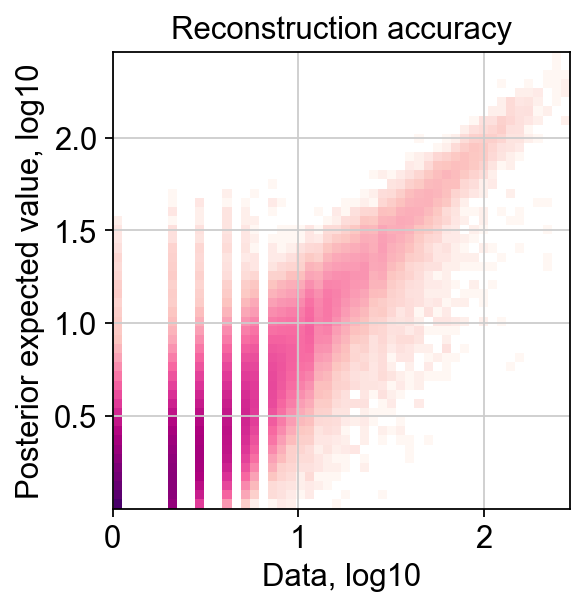

In [34]:
mod.plot_QC()

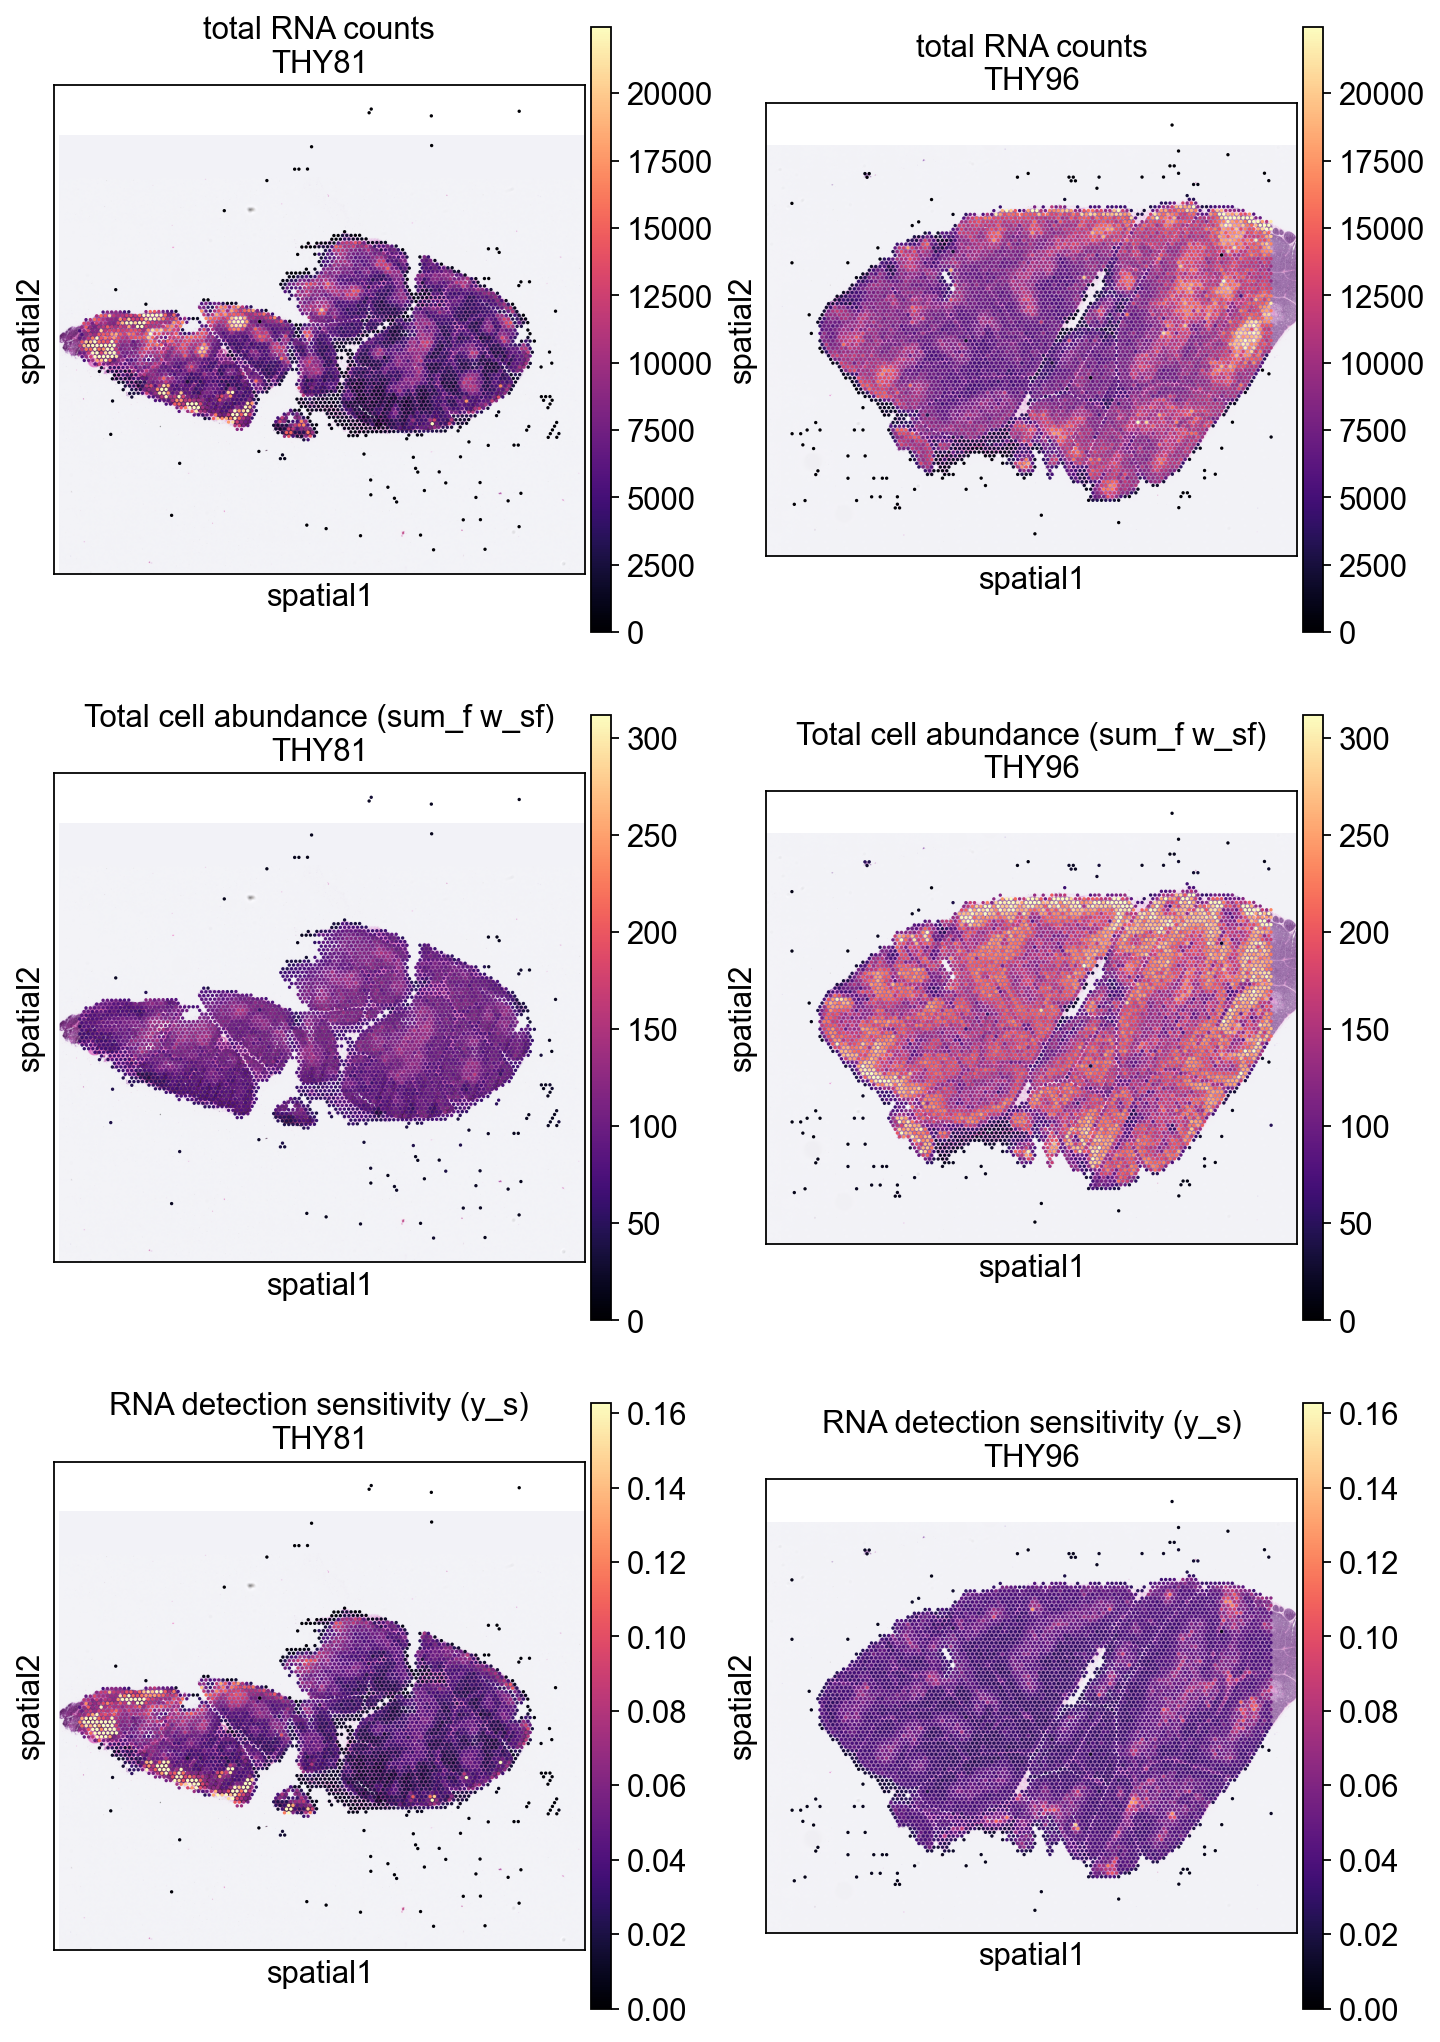

In [35]:
fig = mod.plot_spatial_QC_across_batches()

# consider restarting kernel before this state to prevent GPU from crashing


# load model and visium data 
adata_vis = ad.read_h5ad(f"{run_name}/adata_vis.zarr")
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs} #, 'use_gpu': True}
)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file